#### Гауссовы процессы

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from theano import tensor as tt

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext watermark
%watermark --iversions

theano    : 1.0.11
seaborn   : 0.11.1
pandas    : 1.1.4
matplotlib: 3.3.3
scipy     : 1.5.2
arviz     : 0.11.1
numpy     : 1.19.2
pymc3     : 3.10.0



Процесс Дирихле и гауссов процесс применяются в байесовской статистике для создания гибких моделей, в которых количество параметров разрешается увеличивать при росте объема данных.


Гауссовы процессы обеспечивают принципиальное решение для моделирования произвольных функций, позволяя самим данным эффективно определять сложность этих функций, одновременно устраняя или, по крайней мере, минимизируя возможную переподгонку.


Что, если необходимо представить функции в вероятностной форме? Тогда можно сделать то же самое, но отображение должно иметь вероятностную сущность. То есть можно установить каждое значение $y_i$ как случайной переменной с гауссовым распределением с заданным средним значением и дисперсией. Таким образом, мы получаем уже не описание единственной конкретной функции, а описание семейства распределений.

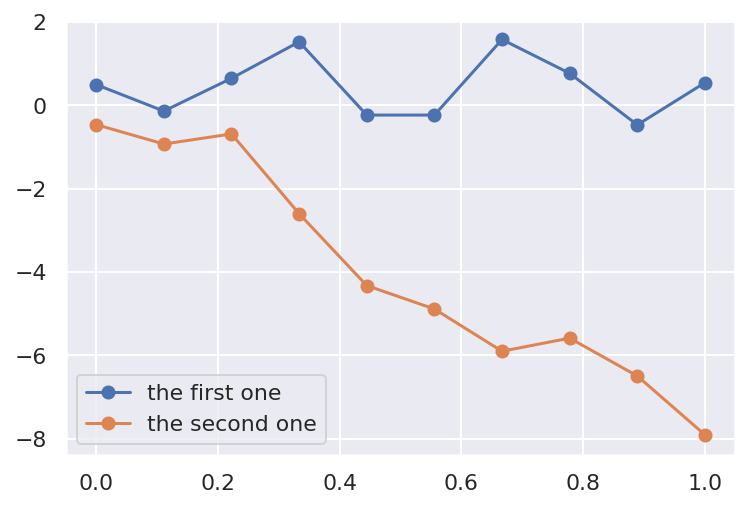

In [3]:
np.random.seed(42)
x = np.linspace(0, 1, 10)

y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='the first one')
y = np.zeros_like(x)

for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')
plt.legend()
plt.show()

На практике может потребоваться генерация диаграммы, подобной изображенной, но с заменой `np.random.normal(0, 1, len(x))` на `np.random.multivariate_normal(np.zeros_like(x), np.eye(len(x)))`.


Первое выражение равнозначно второму, но после замены
можно воспользоваться ковариационной матрицей как способом кодирования информации о том, как точки данных связаны друг с другом.


На практике ковариационные матрицы определяются с использованием функций, называемых ядрами (kernels). Упрощенно, ядро – это в основном симметричная функция, которая принимает два входных значения и возвращает ноль, если входные значения одинаковы, или положительное число в противном случае.


Наиболее часто используемым является экспоненциированное квадратическое ядро:

$$K(x, x')=exp({-\frac{||x-x'||^{2}}{2l^{2}}}),$$

$||x-x'||^{2}$ - евклидово расстояние;

$l-$линейный масштаб, ширина окна, дисперсия, управляет шириной ядра;


Экспоненциированное квадратическое ядро описывается формулой, похожей на формулу гауссова распределения. Поэтому такое ядро иногда называют гауссовым ядром.

In [4]:
def exp_quad_kernel(x, knots, l=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*l**2)) for k in knots])

Как выглядит ковариационная матрица 4×4 для различных входных данных:

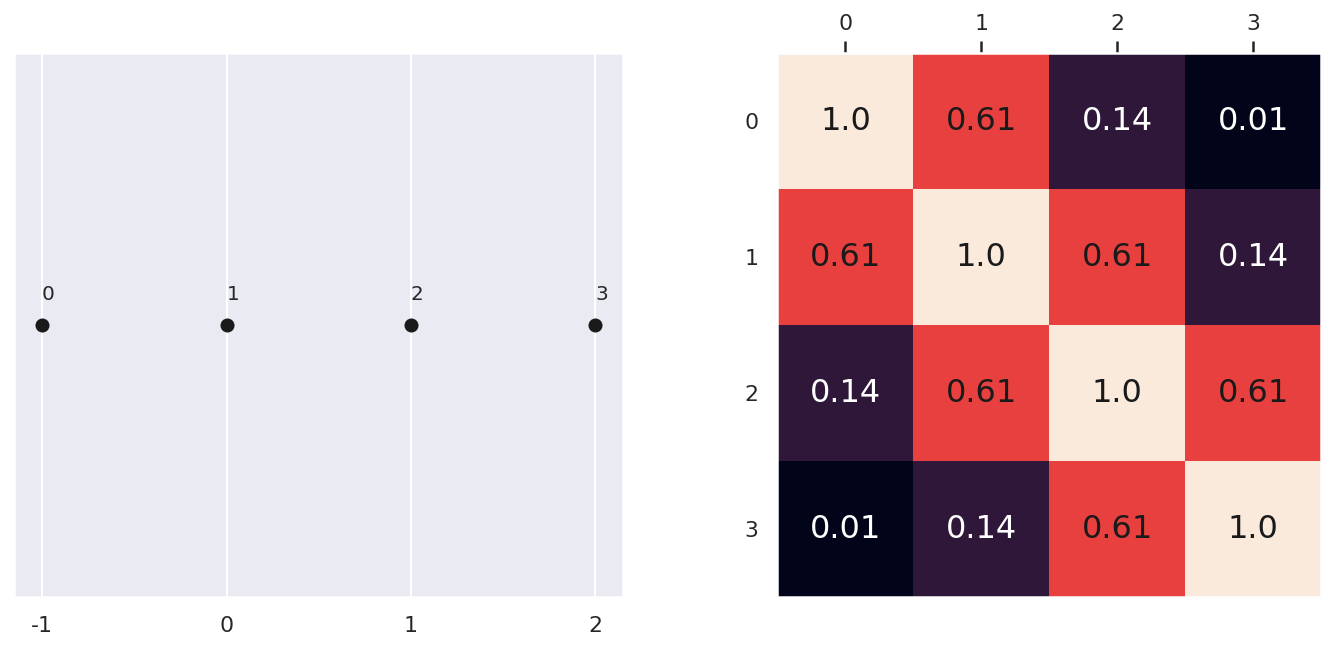

In [5]:
data = np.array([-1, 0, 1, 2])
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])

for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
    
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']

for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
        color=colors[int(im.norm(cov[i, j]) > 0.5)],
        ha='center', va='center', fontdict={'size': 16})

ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

Значение каждого элемента ковариационной матрицы обратно пропорционально расстоянию между точками, а значения на главной диагонали являются результатом сравнения каждой точки данных с самой собой. Мы получаем самое близкое расстояние 0 и самую высокую ковариацию 1 для этого гауссова ядра.

Таким образом:

__Ядро выполняет преобразование расстояния между точками данных__ по оси x в значения ковариаций для значений ожидаемой функции (по оси y). Таким образом, чем ближе две точки по оси x, тем более похожими ожидаются их значения по оси y.

Применим `exp_quad_kernel` для определения ковариационной матрицы многомерного нормального распределения. Затем используем выборку из этого распределения для представления функций:

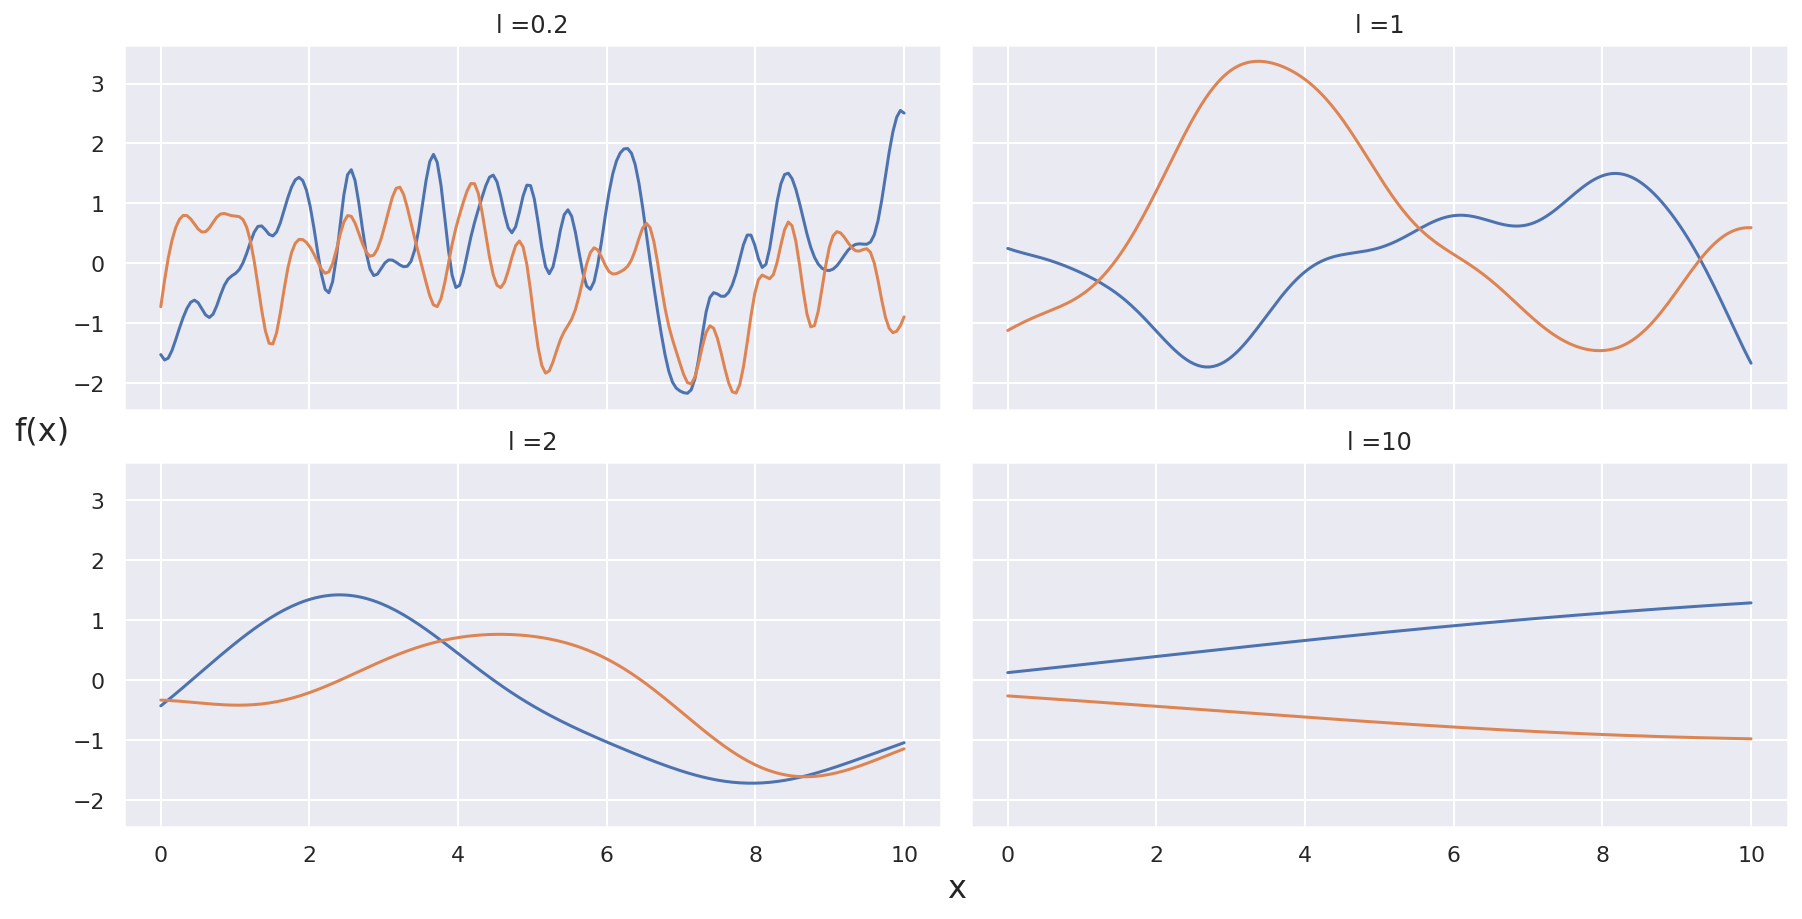

In [6]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, l in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, l)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'l ={l}')
    
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)
plt.show()

Как можно видеть, гауссово ядро подразумевает большое разнообразие функций с параметром $l$, управляющим степенью гладкости этих функций. Чем больше значение $l$, тем более гладкой является функция.

В теории вероятностей и статистике __гауссов процесс__ – это стохастический процесс (совокупность случайных величин, индексированных некоторым параметром, чаще всего временем или координатами), такой, что любой конечный набор этих случайных величин имеет многомерное нормальное распределение, то есть любая конечная линейная комбинация из них нормально распределена.


Гауссовы процессы удобны для создания байесовских непараметрических моделей, поскольку их можно использовать как априорные распределения для функций.

#### Регрессия на основе гауссовых процессов

$$y \sim N(\mu=f(x), \sigma=\varepsilon)$$
$$\epsilon \sim N(0, \sigma_{\varepsilon})$$

Основное различие от предыдущей вероятностной постановки регрессии в том, что априорное распределение теперь получается с помощью функции $f$.

$$f(x) \sim GP(\mu_{x}, K(x, x')),$$

$GP-$  гауссов процесс, с функцией среднего значения $\mu_{x}$, ядром(ковариационной функцией) $K(x, x').$

Если априорное распределение является гауссовым процессом, а правдоподобие – нормальным распределением, то апостериорное распределение также является гауссовым процессом, и его можно вычислить аналитически:

$$p(f(X_{*}| X_{*}, X, y)) \sim N (\mu, \Sigma),$$
$$\mu=K_{*}^T K^{-1} y,$$
$$\Sigma = K_{**}-K_{*}^{T}K^{-1}K_{*}, $$ где:

$K = K(X, X)$

$K_* = K(X_*, X)$

$K_{**} = K(X_*, X_*)$

$X-$ наблюдаемые тчоки данных,  $X_*-$ тестовые точки, новые точки, где мы хотим узгнать значение выводимой функции.

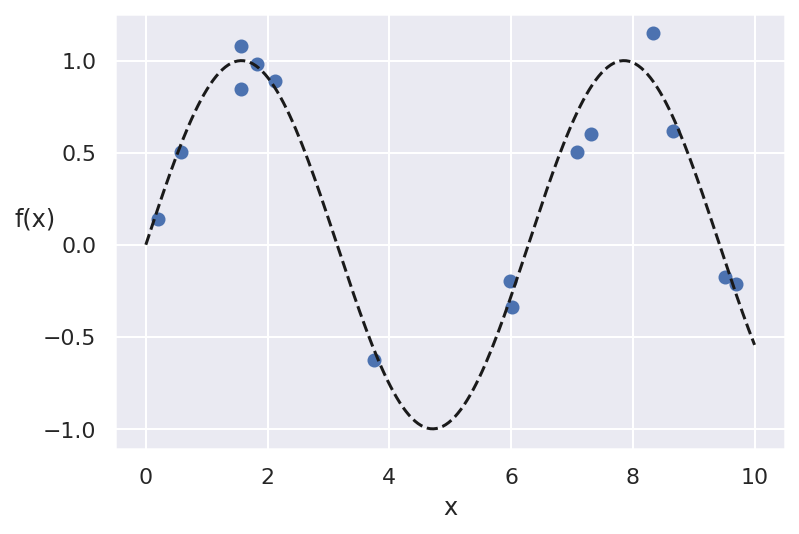

In [7]:
np.random.seed(42)

x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)

plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)
plt.show()

Гауссов процесс в PyMC3:

In [8]:
# Одномерный вектор входных данных
X = x[:, None]

In [9]:
X.shape

(15, 1)

Подробные рекомендации по принимаемым по умолчанию удобным априорным распределениям можно посмотреть здесь:

https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

In [10]:
with pm.Model() as model_reg:
    
    # Априорное гиперраспределние для линейного масштаба ядра l
    l = pm.Gamma('l', 2, 0.5)
    # Экземпляр ковариационной функции
    cov = pm.gp.cov.ExpQuad(1, ls=l)
    # Экземпляр апиорного распределения на основе гауссова процесса
    gp = pm.gp.Marginal(cov_func=cov)
    
    # Априорное распределение
    eps = pm.HalfNormal('eps', 25)
    
    # Правдоподобие 
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=eps)
    
    trace_reg = pm.sample()

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, l]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'l'}>,
        <AxesSubplot:title={'center':'l'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

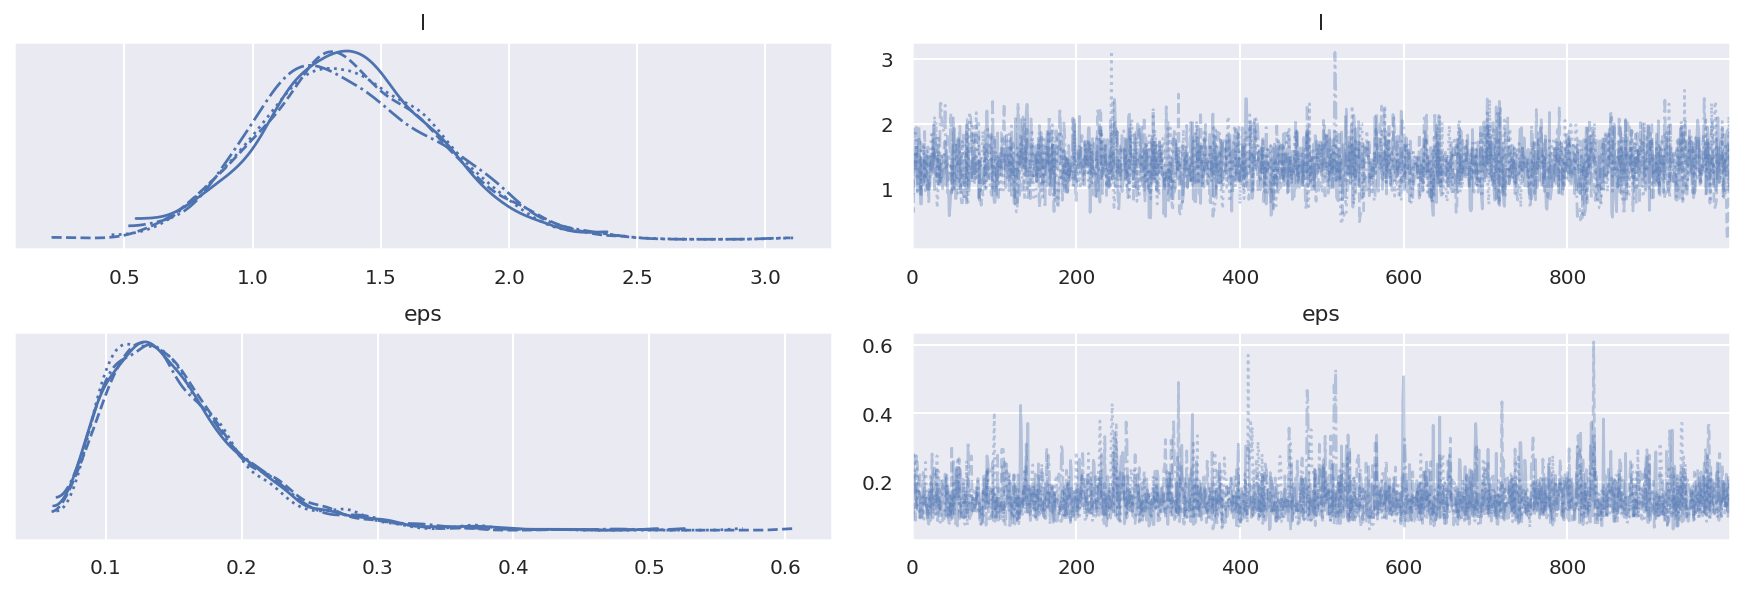

In [11]:
az.plot_trace(trace_reg)

In [12]:
az.summary(trace_reg)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
l,1.378,0.342,0.757,2.015,0.007,0.005,2327.0,2327.0,2238.0,1667.0,1.0
eps,0.154,0.056,0.071,0.255,0.001,0.001,2277.0,2179.0,2432.0,2257.0,1.0


Оценив параметры $l, \varepsilon$, можно получать выборки из апостериорного гауссовского процесса GP. Это можно сделать, вычисляя условное распределение на новых точках входа с `gp.conditional`.



In [13]:
X_new = np.linspace(np.floor(x.min()), 
                    np.ceil(x.max()), 
                    100).reshape(100, 1)

In [14]:
with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

Мы получили новую случайную переменную `f_pred`, которую можно использовать для получения выборок из апостериорного предиктивного распределения, оцененного на `X_new`

In [15]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, 
                                                  vars=[f_pred],
                                                  samples=82)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [16]:
pred_samples['f_pred'].shape

(82, 100)

Изобразим подогнанные функции с учетом оригинальных данных для оценки подгонки и уровня неопределенности `uncertainty`.

Text(0.5, 0, 'X')

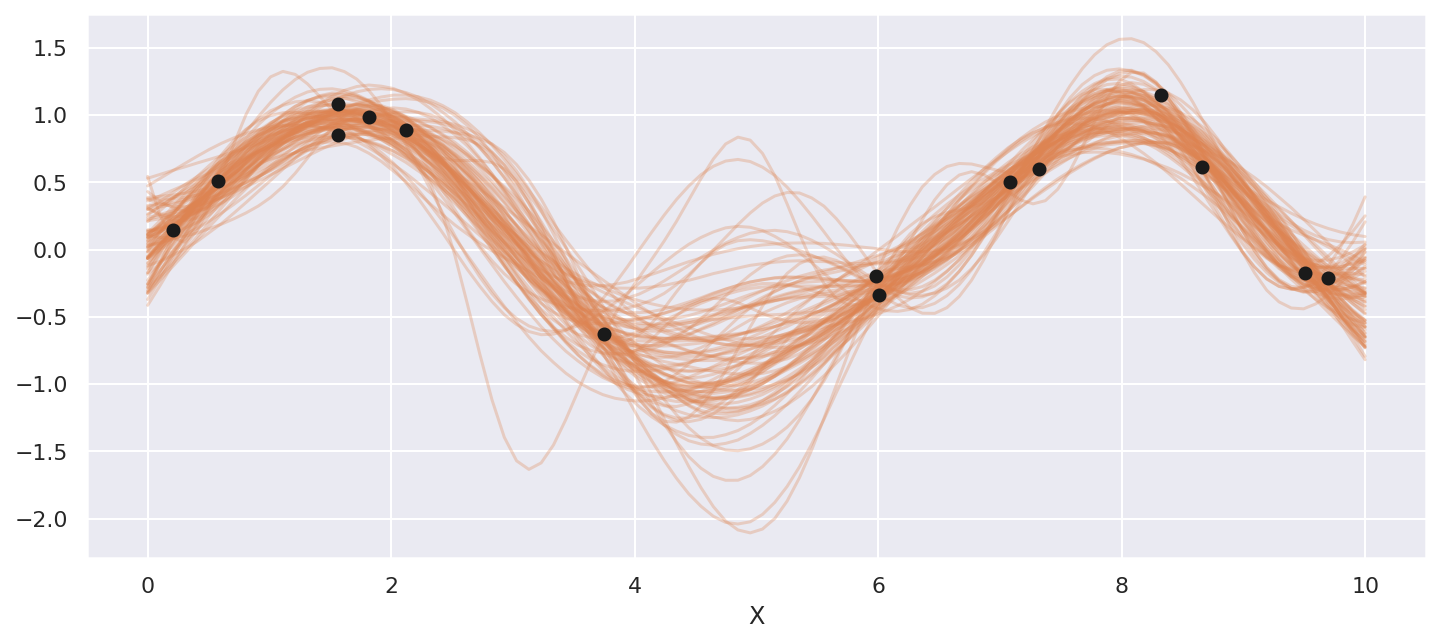

In [17]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

График с pymc3 с учетом неопределенности:

Text(0, 0.5, 'f(x)')

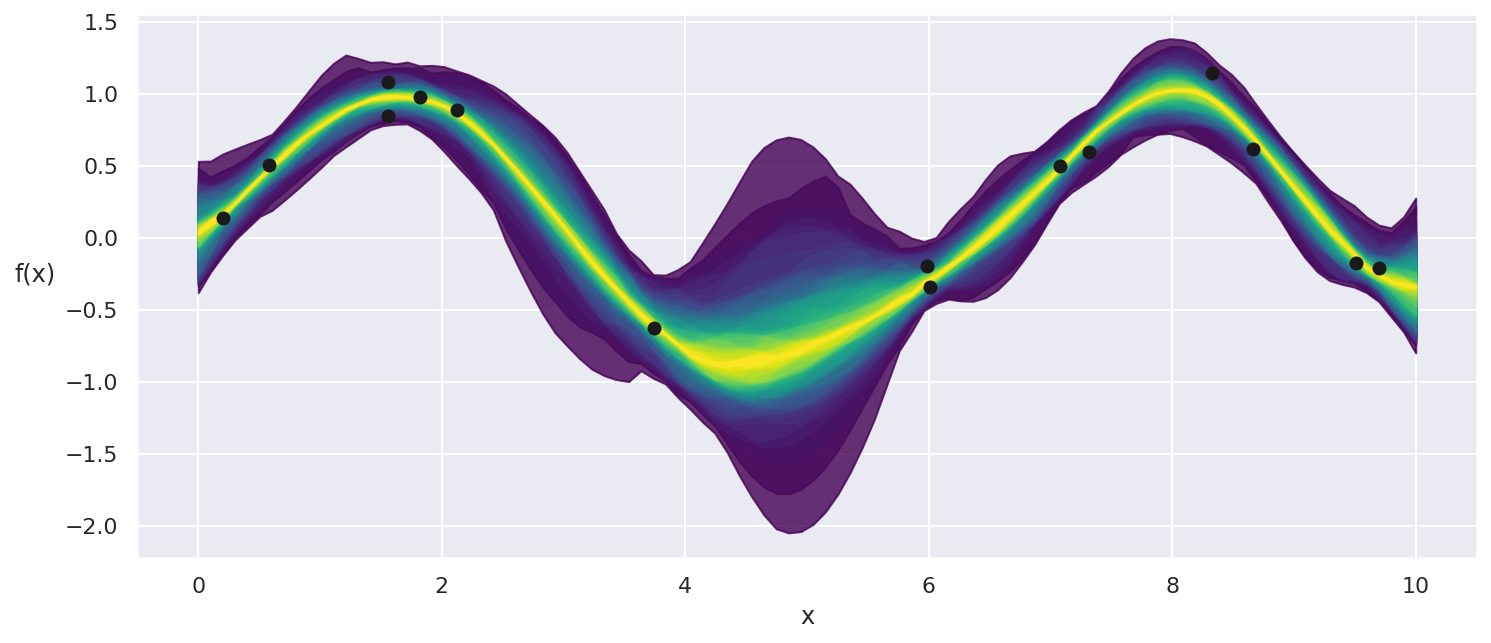

In [18]:
_, ax = plt.subplots(figsize=(12,5))
pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new,
palette='viridis', plot_samples=False);
ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)

Мы также можем оценить вектор средних знаений и стандартных отклонений условного распределения, оцененного с учетом подаваемых $X_{new}$. мы можем этов ыполнит, поскольку PyMC3 выполнил оценку апостериорного рапсределения аналитически:

In [19]:
point = {'l': trace_reg['l'].mean(), 
         'eps': trace_reg['eps'].mean()
        }
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

In [20]:
mu.shape

(100,)

In [21]:
sd.shape

(100,)

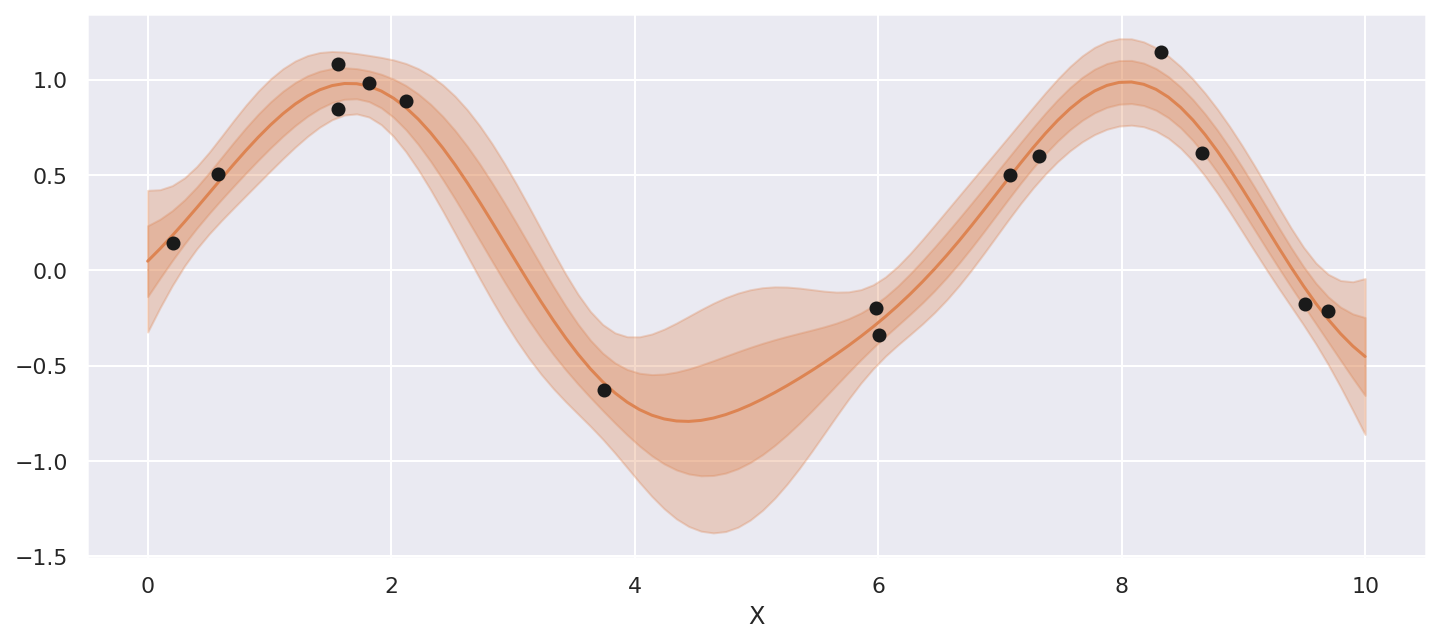

In [22]:
_, ax = plt.subplots(figsize=(12,5))

ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(), mu - sd, mu + sd, 
                color="C1", alpha=0.3)
ax.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, 
                color="C1", alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.show()

Линейную модель можно использовать не с гаусовским правдоподобием, а с учетом подходящей функцией обратной связи, о чем говорилось в GLM-части.

То же самое распространяется и для GP - гауссова процесса. Например, можно использовать правдоподобие на основе распределения Пуассона с экспоненциальной функцией обратной связи. Однако, для подобных моделей аналитическая оценка апостериорного распределения уже невозможна.

#### Регрессия с пространственной автокорреляцией

Разберем пример книги "Statistical Rethinking" (больше примеров из этой книги с PyMC3: `https://github.com/pymc-devs/resources`)


Есть 10 островных сообществ, каждый из них пользуется определенным набором инстркументов. Некоторая теория говорит, что бОльшие сообщества изобретают и поддерживают больше инструментов, чем небольшие. 

Другой важный фактор - уровень контактов между популяциями.


Количество инструментов - зависимая переменная, значит, можно использовать регрессионную модель Пуассона с независимой переменной - размер популяции. Кроме того, мы можем прологарифмировать уровень популяции, поскольку важно порядковое соотношение этой величины между популяциями, а не абсолютная величина.

Для фиксирования уровня контактов с другими сообществами - создадим категориальную переменную по оценке этого уровня. 


Альтернативный вариант - использовать расстояние между сообществами как промежуточную метрику:

In [23]:
islands_dist = pd.read_csv('data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [24]:
islands = pd.read_csv('data/islands.csv', sep=',')
islands.head(10).round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,9.0
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.1
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.5
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.8
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.5


In [25]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values.reshape((-1, 1)), 
          islands.lon.values.reshape((-1, 1))]

In [26]:
print(x_data[0].shape, x_data)

(10, 1) [array([[-16.3],
       [-12.3],
       [-10.7],
       [  9.5],
       [-17.7],
       [ -8.7],
       [  7.4],
       [ -2.1],
       [-21.2],
       [ 19.9]]), array([[ 167.5],
       [ 168.8],
       [ 166. ],
       [ 138.1],
       [ 178.1],
       [ 150.9],
       [ 151.6],
       [ 146.9],
       [-175.2],
       [-155.6]])]


Рассматриваем следующую модель:

$$f \sim GP([0, ..,0], K(x, x'))$$

$$\mu = \sim exp(\alpha + \beta x + f)$$

$$y \sim Poisson(\mu),$$

$y$ - общее количество инструментов,

$x$ - логарифм популяции.


Вместо предположения о том, что общее количество типов инструментов зависит только от численности населения и не зависит от того или иного сообщества, мы моделируем количество типов инструментов в каждом сообществе как функцию их географической близости.

In [27]:
with pm.Model() as model_islands:
    
    eta = pm.HalfCauchy('eta', 1)
    l = pm.HalfCauchy('l', 1)
    cov = eta * pm.gp.cov.ExpQuad(1, ls=l)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)
    
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    mu = pm.math.exp(alpha + f[index] + beta*log_pop)
    tt_pred = pm.Poisson('tt_pred', mu, observed=total_tools)
    
    trace_islands = pm.sample(1000, tune=1000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/gp/cov.py:97: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  UserWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, f_rotated_, l, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 486 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5669642688504368, but should be close to 0.8. Try to increase the number of tuning steps.
There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5837436600094147, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Чтобы понять апостериорное распределение ковариационных функций
с учетом расстояний, можно сформировать диаграммы нескольких выборок из апостериорного распределения:

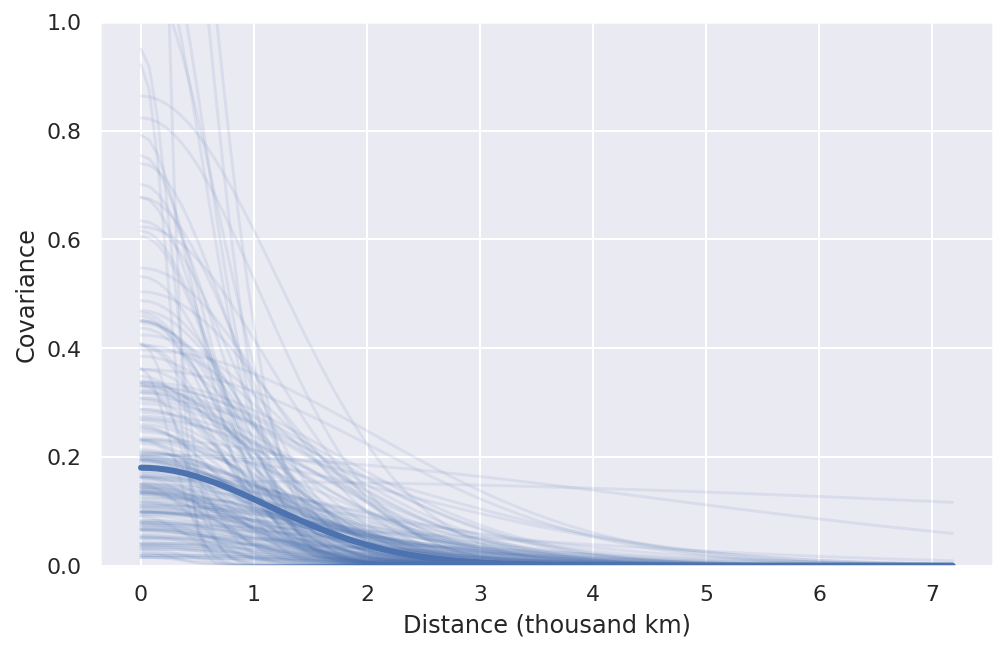

In [28]:
trace_eta = trace_islands['eta']
trace_l = trace_islands['l']

_, ax = plt.subplots(1, 1, figsize=(8, 5))

xrange = np.linspace(0, islands_dist.values.max(), 100)
ax.plot(xrange, 
        np.median(trace_eta) * np.exp(-np.median(trace_l) * xrange**2),
        lw=3)
ax.plot(xrange, 
        (trace_eta[::20][:, None] * np.exp(- trace_l[::20][:, None] *xrange**2)).T,
        'C0', 
        alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('Distance (thousand km)')
ax.set_ylabel('Covariance')
plt.show()

In [29]:
np.median(trace_eta[::20][:, None])

0.17611876762349354

You may find it interesting to compare model_islands , and the posterior computed from it, with model `m_10_10 in https:// github.com/pymc-devs/resources` . You may want to
use ArviZ functions, such as az.summary or `az.plot_forest`. Model `m_10_10` is similar to model_islands , but without including a Gaussian process term.

In [30]:
# Compute posterior median covariance among societies
sigma = np.median(trace_eta) * (np.exp(-np.median(trace_l) * islands_dist_sqr))

# Convert to correlation matrix
sigma_post = np.diag(np.diag(sigma)**-0.5)


rho = np.dot(np.dot(sigma_post, sigma), sigma_post)
rho = pd.DataFrame(rho, index=islands_dist.columns,
                   columns=islands_dist.columns
                  )
rho.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.92,0.86,0.00,0.55,0.20,0.02,0.05,0.26,0.0
Ti,0.92,1.00,0.96,0.00,0.55,0.21,0.04,0.06,0.22,0.0
SC,0.86,0.96,1.00,0.00,0.39,0.32,0.07,0.12,0.13,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.09,0.39,0.36,0.00,0.0
Fi,0.55,0.55,0.39,0.00,1.00,0.02,0.00,0.00,0.80,0.0
Tr,0.20,0.21,0.32,0.09,0.02,1.00,0.28,0.75,0.00,0.0
Ch,0.02,0.04,0.07,0.39,0.00,0.28,1.00,0.56,0.00,0.0
Mn,0.05,0.06,0.12,0.36,0.00,0.75,0.56,1.00,0.00,0.0
To,0.26,0.22,0.13,0.00,0.80,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


Гавайи (Hawaii) представляют собой чрезвычайно уединенное сообщество, поскольку расположено очень далеко от остальных островных сообществ. Также можно видеть, что Малекула (Malekula, Ml), Тикопиа (Tikopia, Ti) и Санта Крус (Santa Cruz, SC) сильно коррелируют друг с другом. Причина в том, что эти сообщества расположены очень близко друг к другу, а кроме того, количество типов инструментов в этих сообществах различается незначительно.

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


(10.0, 73.0)

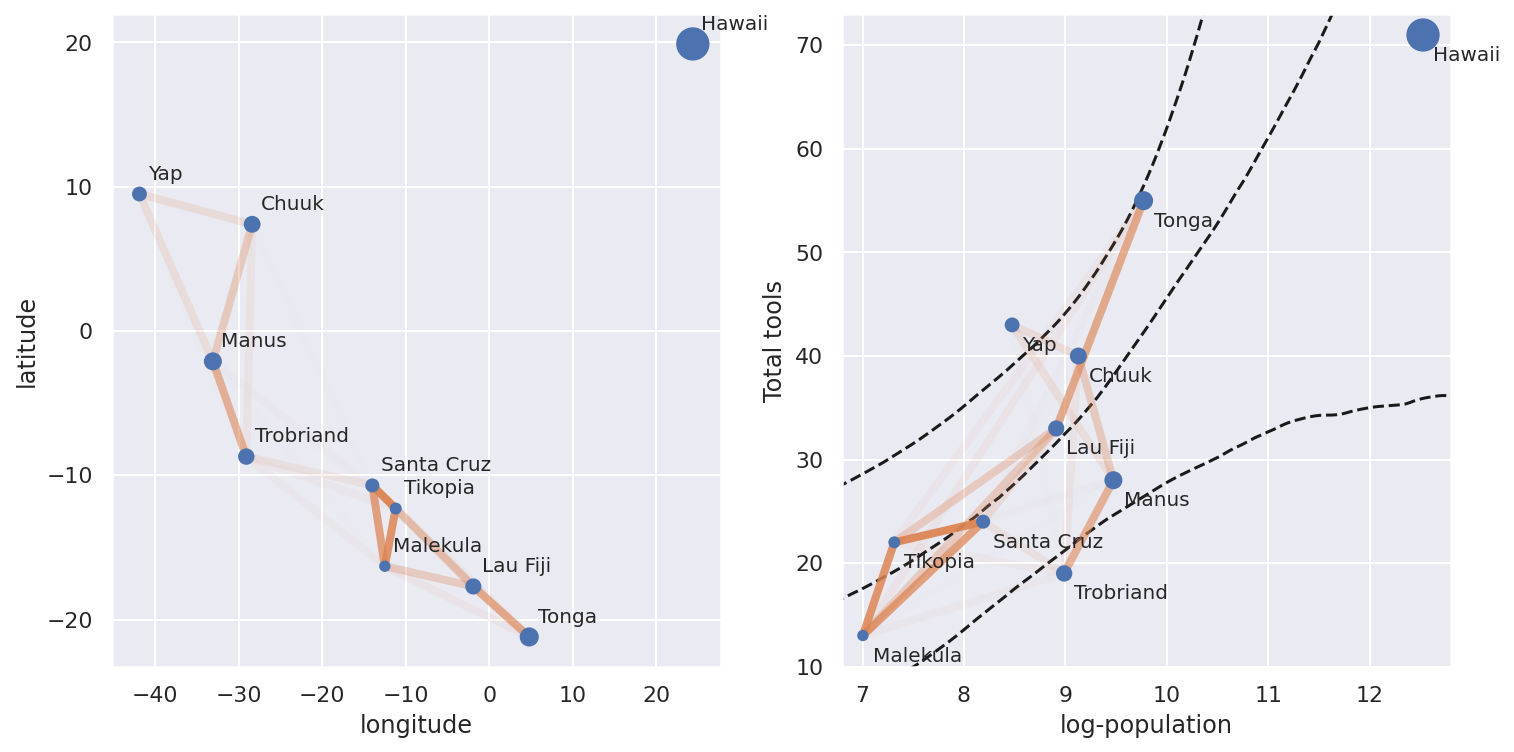

In [31]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(trace_islands['alpha'][:, None] + trace_islands['beta'][:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)
    
ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')
az.plot_hpd(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1}
           )

for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot(
            (islands.lon2[i], islands.lon2[j]), 
            (islands.lat[i], islands.lat[j]), 'C1-',
            alpha=rho.iloc[i, j]**2, lw=4
        )
        
        ax[1].plot(
            (islands.logpop[i], islands.logpop[j]),
            (islands.total_tools[i], islands.total_tools[j]), 
            'C1-', alpha=rho.iloc[i, j]**2, lw=4
        )

ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

ax[1].set_xlabel('log-population')
ax[1].set_ylabel('Total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)

В левой части показаны линии корреляций апостериорного раcпределения медианы, ранее вычисленные по островным сообществам на оcнове их относительного географического положения. Некоторые из линий не видны, поскольку уровень корреляции использовался для установки степени прозрачности линий `alpha`.

В правой части изображены те же корреляции апостериорного распределения медианы, но
отображаемые в соотношении количества типов инструментов и логарифма от численности населения. 

Штриховые линии представляют срединные значения (медианы) количества инструментов и интервал ПАР 94 % как функцию от логарифма численности населения. На обеих диаграммах размер точек пропорционален численности населения каждого островного сообщества.

#### Классификация с применением гауссова процесса

В части про GLM было показано, что регрессионная модель с логистической функцией обратной связи и правдоподобием с использованием распределения Бернулли решает задачу классификации.

Возьмем пример iris_dataset и используем GP вместо линейной модели. 

In [32]:
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [37]:
df = iris[iris['species'].isin(['setosa', 'versicolor'])]
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1.reshape((-1, 1))

Вместо `pm.gp.Marginal` для инициализации априорного распределения в виде гауссова процесса GP, используем в этом примере `pm.gp.Latent`.

`Latent` - обобщение, может быть использовано со всеми вариантами правдоподобия.

`Marginal` выполнен специально для гауссовских правдоподобий и имеет преимущество в эффективности вычислений, поскольку с гауссовым правдоподобием и априорным распределением  гауссова процесса GP  становится возможным аналитический вывод.

In [41]:
with pm.Model() as model_iris:
    
    # Априорные распределения
    l = pm.Gamma('l', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, l) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    
    # Логистическая функция обратной связи и правдоподобие Бернулли
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    # Для ускорения семплинга в этом примере возьмем 2 цепочки
    trace_iris = pm.sample(1000, chains=2, 
                           compute_convergence_checks=True)
    

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f_rotated_, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 115 seconds.


Аналогично с `marginal_gp_model` можно взять условное распределение, оцененное на множестве новых точек входа с помощью `gp.conditional`:

In [42]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)
X_new = X_new.reshape((-1, 1))

In [43]:
with model_iris:
    f_pred = gp.conditional('f_pred', X_new)

In [44]:
with model_iris:
    pred_samples = pm.sample_posterior_predictive(
    trace_iris, vars=[f_pred], samples=50
    )

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [45]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

In [50]:
def logistic(x):
    return 1/(1+np.exp(-x))

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:341: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


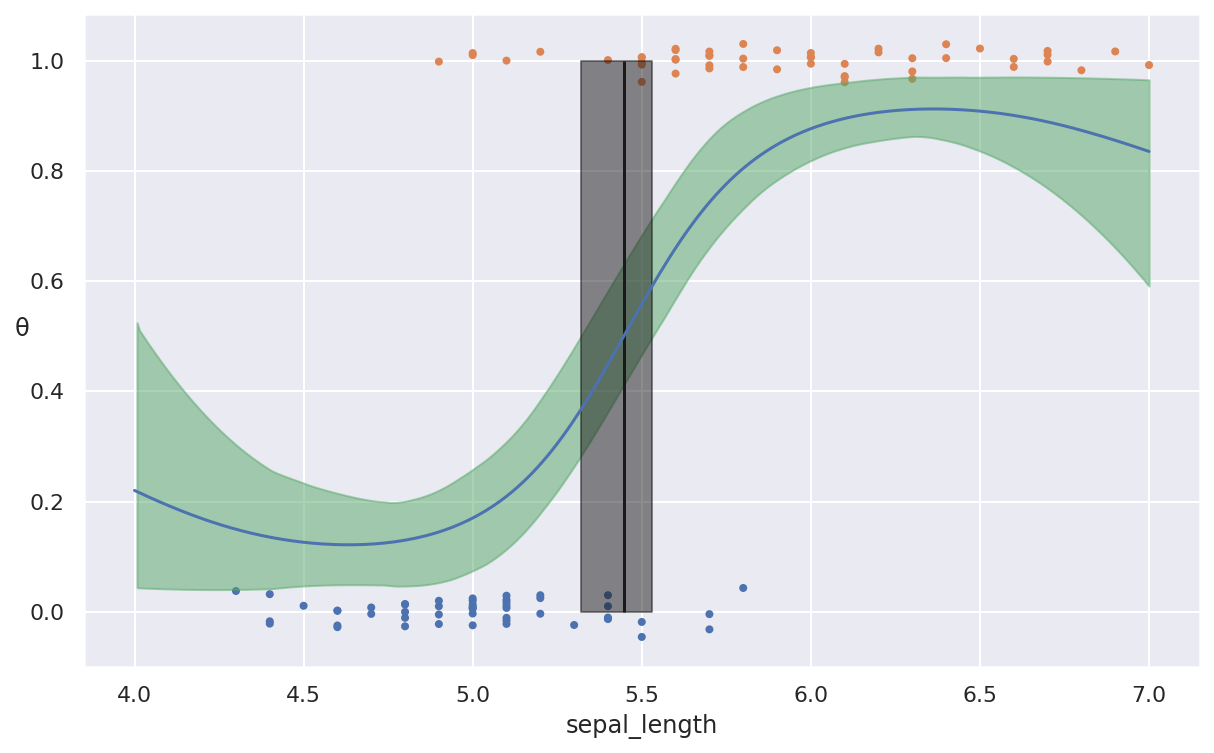

In [52]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
marker='.', color=[f'C{x}' for x in y])

az.plot_hpd(X_new[:, 0], fp, color='C2')

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.show()

На графике сигмоиды должна быть особенность - понижение и понижение хвостов, поскольку в крайних значениях мало данных, и результат стремится к априорному распределению. Это можно поправить.

Общий способ получить модель с гауссовским процессом лучше - комбинация ковариационных функций для учета больших деталей:

`cov = K_{ExpQuad} + K_{Linear} + K_{whitenoise}(1E-5)`

`whitenoise kernel` - это вычислительный трюк для стабилизации расчета ковариационной матрицы.

Ядра для гауссовых процессов ограничены, чтобы гарантировать, что результирующая матрица ковариации является положительно определенной. Проблема в том, что могут появляться `nan` при вычислении апостериорных прогнозируемых выборок. Вариант решения этой ошибки - добавление ошибки. В целом это происходит под капотом PyMC3, но, к сожалению, иногда этого бывает недостаточно.

Именно поэтому этот трюк также добавлен в предыдущем примере.

In [55]:
with pm.Model() as model_iris2:
    
    l = pm.Gamma('l', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    tau = pm.HalfNormal('tau', 5)
    
    cov = pm.gp.cov.ExpQuad(1, l) + \
          tau*pm.gp.cov.Linear(1, c) + \
          pm.gp.cov.WhiteNoise(1e-5)
    
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    
    # Bernoulli likelihood with logistic inverse link func
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    
    # 1 цепочка, без проверок - для скорости
    trace_iris2 = pm.sample(1000, chains=1, 
                            compute_convergence_checks=False)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, tau, c, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 138 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.


Сгенерируем выборки из апостериорного прогнозируемого распределения:

In [56]:
with model_iris2:
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris2,
                                                  vars=[f_pred],
                                                  samples=1000
                                                 )

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:341: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0, 0.5, 'θ')

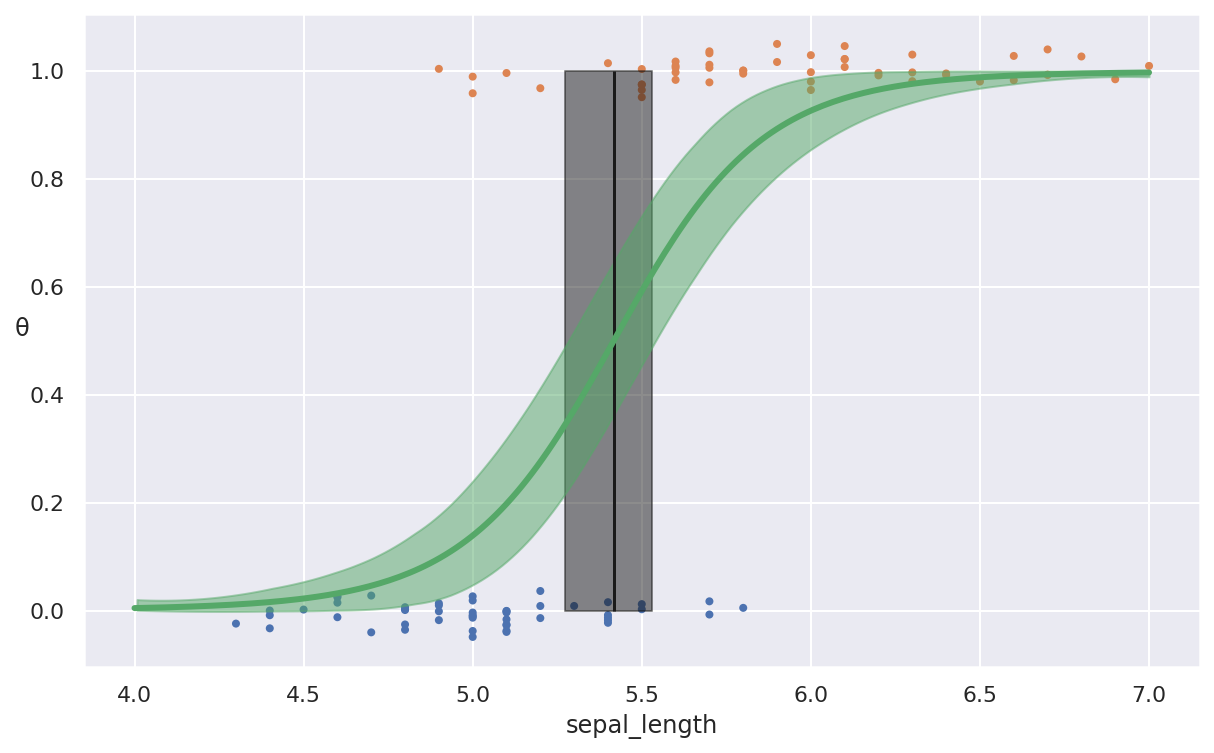

In [57]:
_, ax = plt.subplots(figsize=(10,6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.scatter(x_1, np.random.normal(y, 0.02), 
           marker='.',color=[f'C{ci}' for ci in y])

db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], 
                 color='k', alpha=0.5)

ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hpd(X_new[:,0], fp, color='C2')

ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

Таким образом, комбинация различных ядер помогла поправить проблему.

Конечно, с практической точки зрения GP для решения задачи, которой уже достаточно только логистической регрессии - избыточно.

GP можно использовать для моделирования более сложных данных. Например, необходимо моделировать вероятность получения заболевания как функцию от возраста. Эмпирически ясно, что самые молодые и пожилые имеют большие шансы.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0, 0, 'healthy'), Text(0, 1, 'sick')]

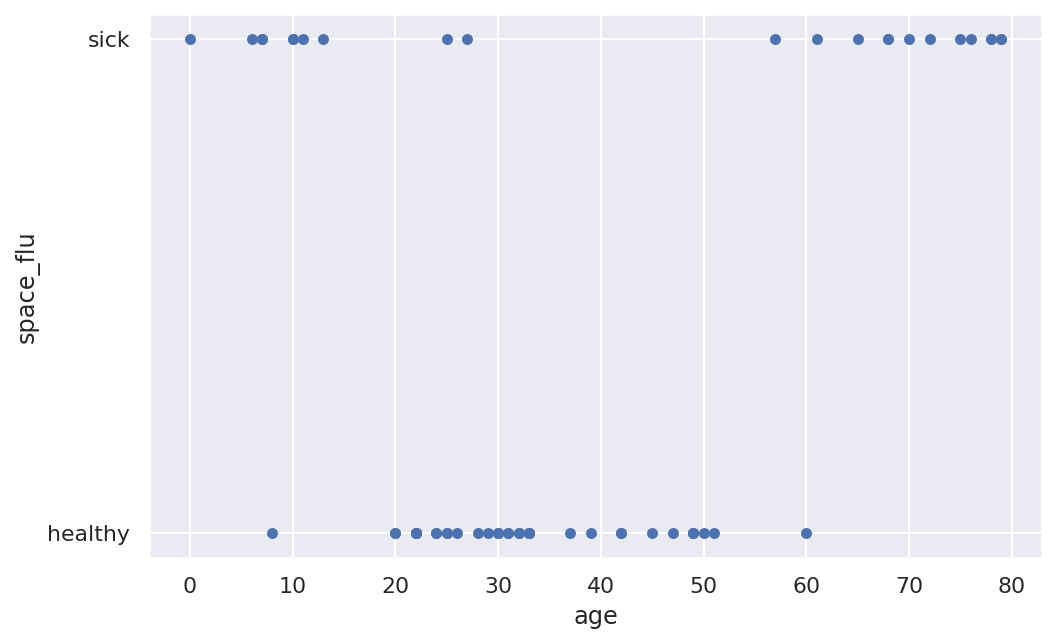

In [58]:
df_sf = pd.read_csv('data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])

In [61]:
with pm.Model() as model_space_flu:
    
    l = pm.HalfCauchy('l', 1)
    cov = pm.gp.cov.ExpQuad(1, l) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=age)
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=space_flu)
    trace_space_flu = pm.sample(1000, chains=1,
                               compute_convergence_checks=False)
    

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 10 seconds.


In [62]:
X_new = np.linspace(0, 80, 200).reshape((-1, 1))

with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(
        trace_space_flu,vars=[f_pred],samples=1000
    )

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


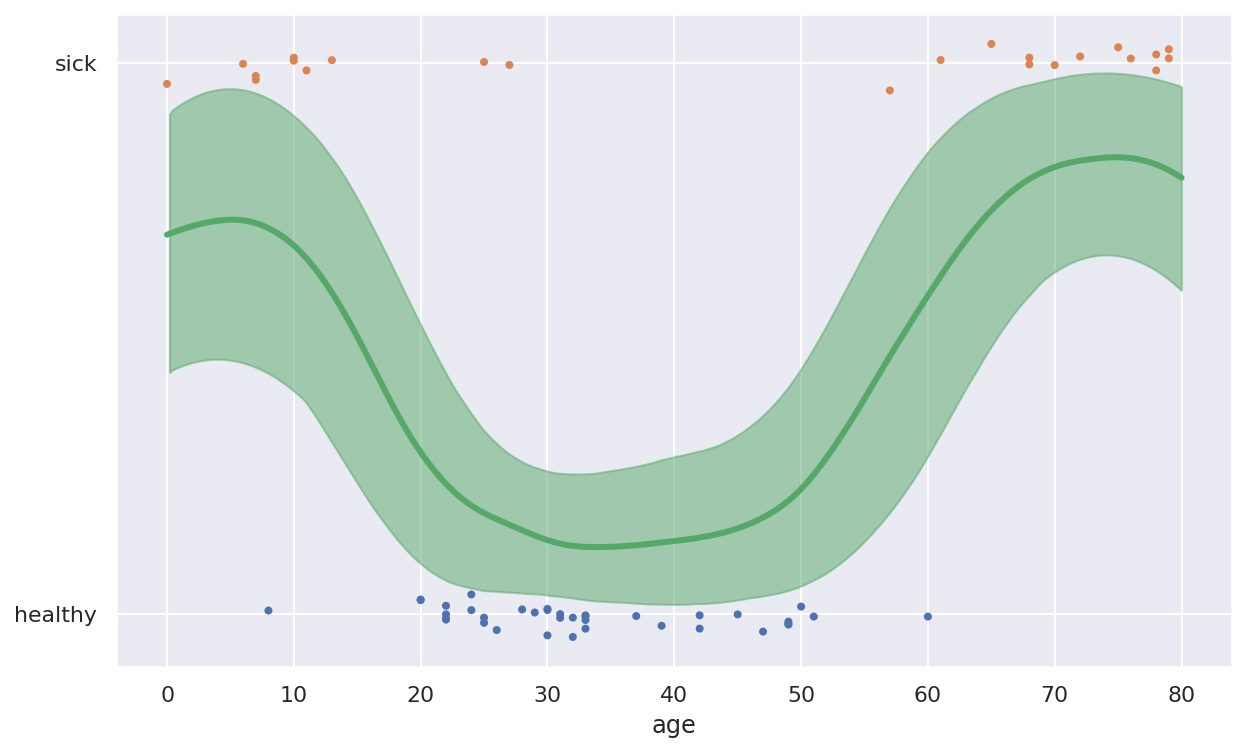

In [63]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.nanmean(fp, 0)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)
az.plot_hpd(X_new[:, 0], fp, color='C2')

ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')
plt.show()

Вот пример действительно большой пользы гауссовых процессов. Классической логистической регрессией невозможно было бы учесть особенности в хвостах этой кривой, пока не сделать несколько её дополнительных модификаций.

#### Cox process

Будем использовать гауссовский процесс для решения задачи по оценке уровня интенсивности некоторой величины. Для моделирования уровня интенсивности используется распределение Пуассона.

Можно представить Пуассоновский процесс как распределение набора точек в заданном пространстве. Когда уровень интенсивности процесса Пуассона - сам по себе случайный процесс, например, гауссов процесс, то мы получаем __Cox process__.

#### The coal-mining disasters 

Есть датасет с записями катастроф в шахтах добычи угля 1851-1962. Количество катастроф регулируется правилами безопасности, улучшаемыми в этот период.

Попробуем моделировать интенсивность, уровень катастроф как функцию от времени. Такая формулировка подводит нас к регрессии Пуассона, где интенсивность катастроф - гауссов процесс:


$$f(x) \sim GP(\mu_{x}, K(x, x'))$$

$$y \sim Poisson(f(x))$$

In [3]:
df_coal = pd.read_csv('data/coal.csv', header=None)
df_coal.head()

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


In [5]:
df_coal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       191 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


In [12]:
df_coal['year'] = df_coal[0].astype(int)
df_coal['year'].unique()

array([1851, 1852, 1853, 1854, 1856, 1857, 1858, 1860, 1861, 1862, 1863,
       1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875,
       1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886,
       1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1899,
       1901, 1902, 1905, 1906, 1908, 1909, 1910, 1912, 1913, 1914, 1916,
       1918, 1922, 1923, 1927, 1928, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1946, 1947, 1951, 1957,
       1960, 1962])

In [16]:
df_coal_grp = df_coal.groupby(by=['year'])[0].count().reset_index()
df_coal_grp.columns = ['year', 'cases']
df_coal_grp.head()

,year,cases
0,1851,4
1,1852,5
2,1853,4
3,1854,1
4,1856,4


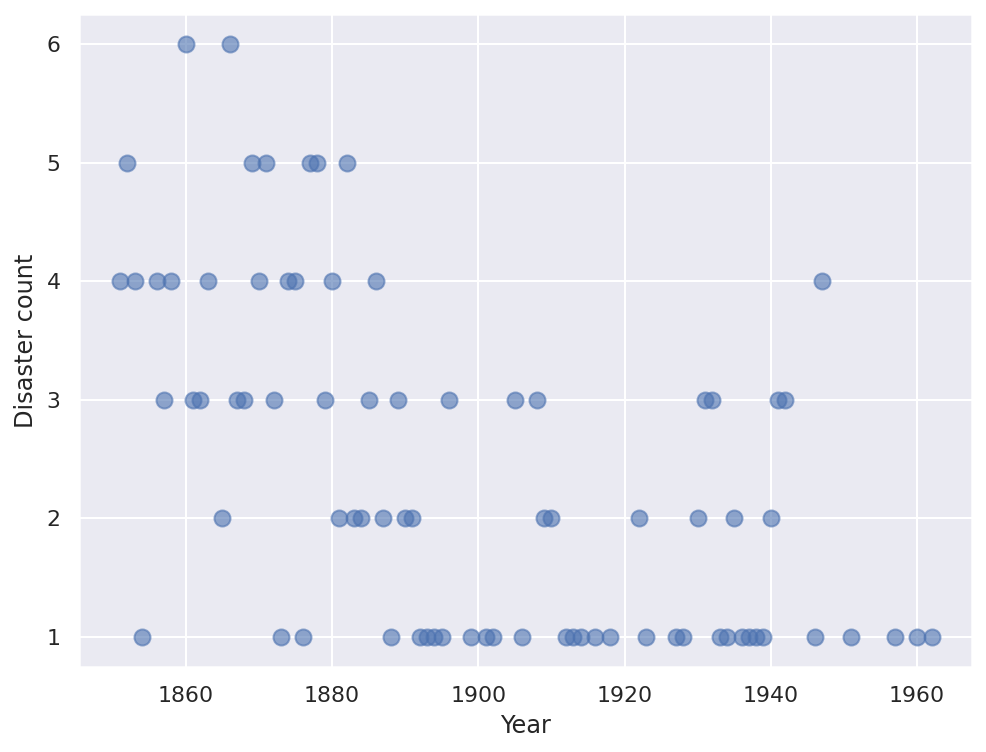

In [20]:
fig = plt.figure(figsize=(8, 6))
plt.plot(df_coal_grp['year'], df_coal_grp['cases'], "o", markersize=8, alpha=0.6)
plt.ylabel("Disaster count")
plt.xlabel("Year")
plt.show()

Предобработаем данные, сделав временную дискретизацию по корзинам:

In [18]:
years = int(df_coal.max().values.astype(int) - df_coal.min().values.astype(int))
years

111

In [19]:
bins = years//4
bins

27

In [25]:
hist, x_edges = np.histogram(df_coal, bins=bins)
# Находим центры корзин
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2

In [26]:
x_centers

array([1853.25847222, 1857.37021667, 1861.48196111, 1865.59370556,
       1869.70545   , 1873.81719444, 1877.92893889, 1882.04068333,
       1886.15242778, 1890.26417222, 1894.37591667, 1898.48766111,
       1902.59940556, 1906.71115   , 1910.82289444, 1914.93463889,
       1919.04638333, 1923.15812778, 1927.26987222, 1931.38161667,
       1935.49336111, 1939.60510556, 1943.71685   , 1947.82859444,
       1951.94033889, 1956.05208333, 1960.16382778])

In [27]:
x_data = x_centers.reshape((-1, 1))
y_data = hist/4

In [32]:
with pm.Model() as model_coal:
    
    l = pm.HalfNormal('l', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=l) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x_data)
    
    y_pred = pm.Poisson('y_pred',
                        mu=pm.math.exp(f), 
                        observed=y_data
                       )
    
    trace_coal = pm.sample(1000, chains=1)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/utils.py:661: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/utils.py:661: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will chan

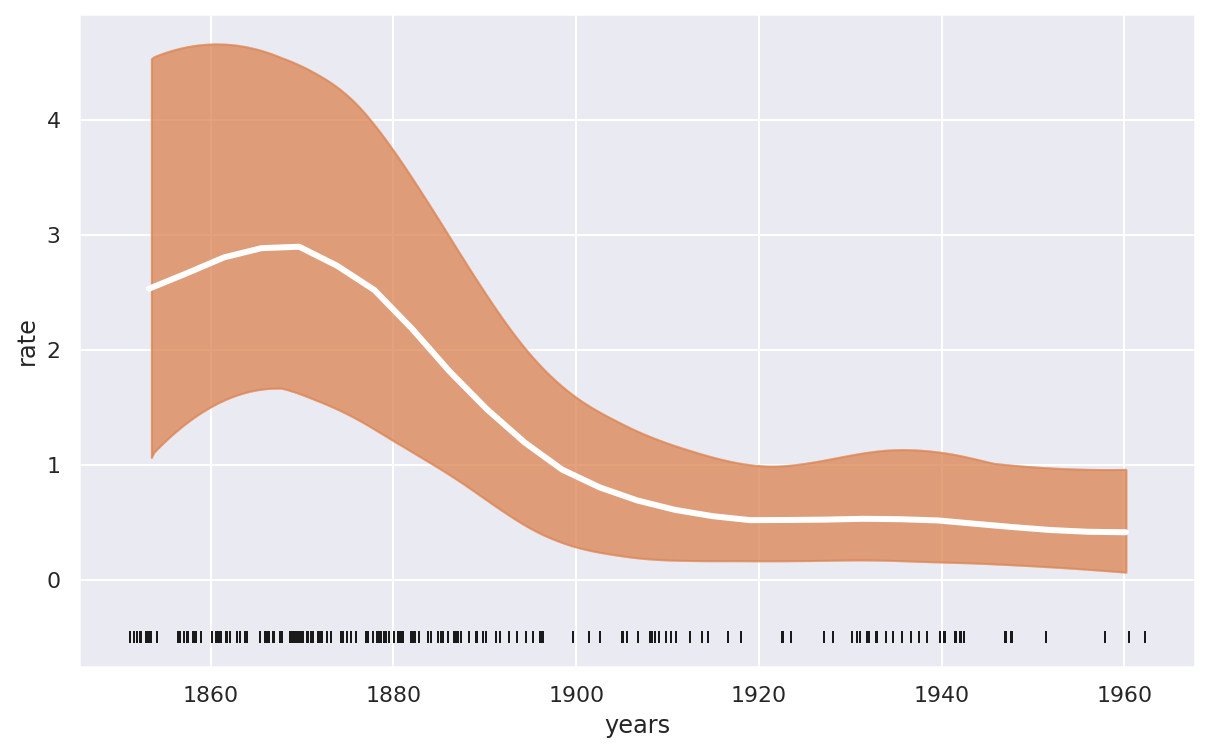

In [41]:
_, ax = plt.subplots(figsize=(10, 6))

f_trace = np.exp(trace_coal["f"])
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)

alpha = 0.1
az.plot_hpd(x_centers, f_trace, 
            credible_interval=1-alpha/2)
az.plot_hpd(x_centers, f_trace, 
            credible_interval=1-alpha/2,
            plot_kwargs={'alpha': 0}
           )

ax.plot(df_coal, np.zeros_like(df_coal)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')
plt.show()

! The PyMC3 documentation includes the coal mining disaster, but modeled from a different perspective.

#### The redwood dataset

Оценим аналогичную модель с 2D-пространственными условиями.
(dataset from GPstuff package for Matlab, Octave, R)

Датасет состоит из локаций деревьев на заданных зонах.
Необходимо понять распределение уровня деревьев в разных зонах.

In [47]:
df_raw = pd.read_csv('./data/redwood.csv', header=None)
df_raw.head()

,0,1
0,0.931481,0.817680
1,0.938889,0.764273
2,0.935185,0.721915
3,0.979630,0.664825
4,0.787037,0.661142


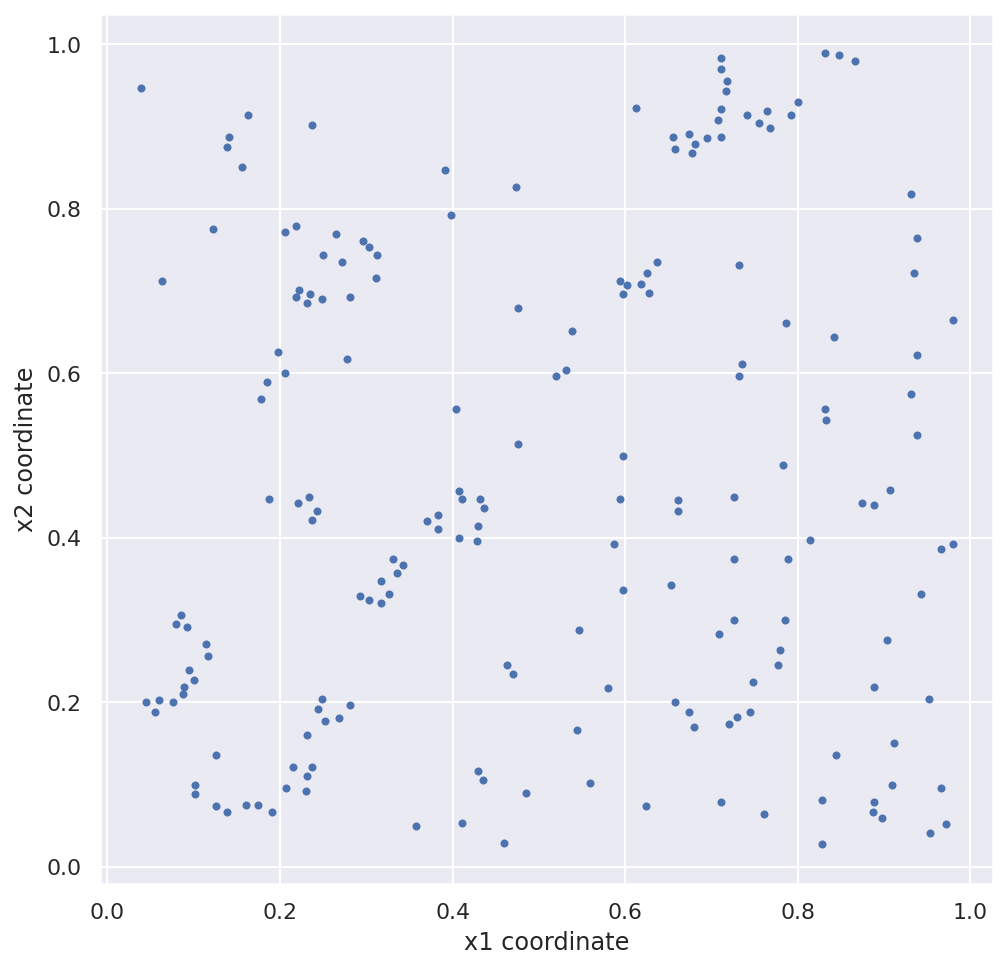

In [49]:
_, ax = plt.subplots(figsize=(8, 8))

ax.plot(df_raw[0], df_raw[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')
plt.show()

Аналогично предыдущей задаче необходимо произвести дискретизацию данных:

In [172]:
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(df_raw[1].values, 
                                          df_raw[0].values,
                                          bins = bins
                                         )

x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0])/2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0])/2

x_data = [x1_centers[:, None], x2_centers[:, None]]

y_data_rw = hist.flatten()

In [173]:
x_data[0].shape

(20, 1)

In [174]:
x_data[1].shape

(20, 1)

In [175]:
x_data

[array([[0.05165746],
        [0.09972376],
        [0.14779006],
        [0.19585635],
        [0.24392265],
        [0.29198895],
        [0.34005525],
        [0.38812155],
        [0.43618785],
        [0.48425415],
        [0.53232044],
        [0.58038674],
        [0.62845304],
        [0.67651934],
        [0.72458564],
        [0.77265194],
        [0.82071824],
        [0.86878453],
        [0.91685083],
        [0.96491713]]),
 array([[0.06240741],
        [0.10944444],
        [0.15648148],
        [0.20351852],
        [0.25055556],
        [0.29759259],
        [0.34462963],
        [0.39166667],
        [0.4387037 ],
        [0.48574074],
        [0.53277778],
        [0.57981482],
        [0.62685185],
        [0.67388889],
        [0.72092593],
        [0.76796296],
        [0.815     ],
        [0.86203704],
        [0.90907407],
        [0.95611111]])]

In [153]:
df_raw.std().values

array([0.28075337, 0.28956177])

In [178]:
with pm.Model() as model_rw:
    
    l = pm.HalfNormal('l', df_raw.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=l[0]) 
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=l[1])
    
    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior("f", Xs=x_data)
    
    y = pm.Poisson("y", mu = pm.math.exp(f), observed=y_data_rw)
    trace_rw = pm.sample(1000, chains=2, 
                         compute_convergence_checks=False
                        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f_rotated_, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.


Изобразим на пространственном графике моделируемый уровень деревьев:

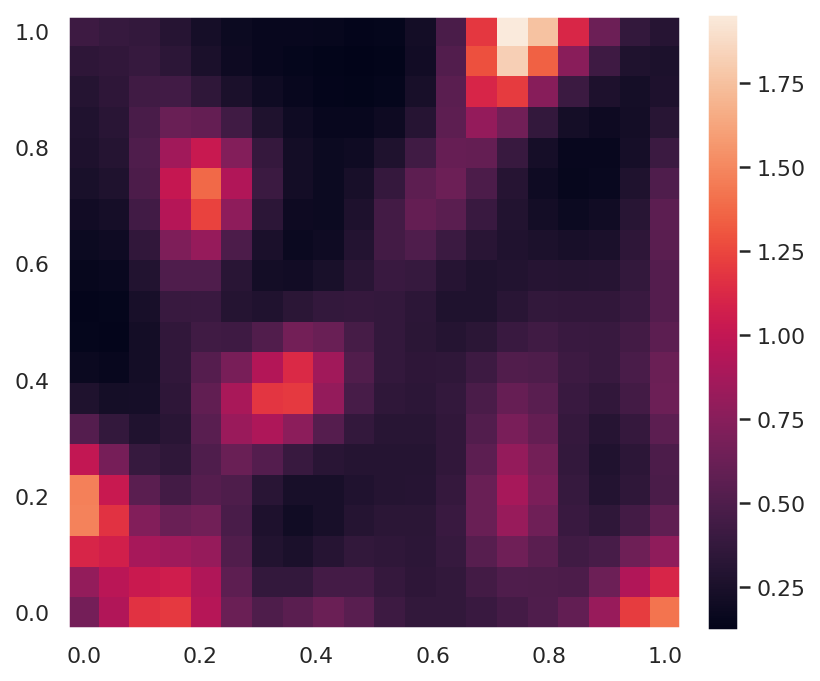

In [179]:
rate = np.exp(np.mean(trace_rw['f'],
                      axis=0).reshape((bins, -1)))

fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)

ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)

ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)